# Products Sephora

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
products = pd.read_csv("product_info.csv")

In [4]:
products.shape

(8494, 27)

In [5]:
products.head(3)

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


## Filas duplicadas

In [7]:
products.product_id.duplicated().sum()

0

No tenemos filas duplicadas

## Tratamiento de nulos

### Porcentaje de nulos en cada columna

In [11]:
(products.isnull().sum() / len(products) * 100).round(2)

product_id             0.00
product_name           0.00
brand_id               0.00
brand_name             0.00
loves_count            0.00
rating                 3.27
reviews                3.27
size                  19.20
variation_type        17.00
variation_value       18.81
variation_desc        85.28
ingredients           11.13
price_usd              0.00
value_price_usd       94.69
sale_price_usd        96.82
limited_edition        0.00
new                    0.00
online_only            0.00
out_of_stock           0.00
sephora_exclusive      0.00
highlights            25.98
primary_category       0.00
secondary_category     0.09
tertiary_category     11.66
child_count            0.00
child_max_price       67.58
child_min_price       67.58
dtype: float64

### Eliminamos columnas por demasiados datos faltantes

In [13]:
products.drop(
    ["variation_desc", "value_price_usd", "sale_price_usd", "child_max_price", "child_min_price", "variation_value"],
    axis = 1,
    inplace = True
)

In [14]:
products.isnull().sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
ingredients            945
price_usd                0
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
dtype: int64

### Transformación de nulos en 'secondary_category' y 'terciary_category'

Completaremos los datos de la 'secondary_category' con los datos del producto de la 'primary_category' y los de 'terciary_category' con los de 'secondary_category'

In [17]:
products['secondary_category'] = products['secondary_category'].fillna(products['primary_category'])
products['tertiary_category'] = products['tertiary_category'].fillna(products['secondary_category'])

### Datos de 'variation_type'
Convertimos la columna 'variation_type' en booleana

In [19]:
products["variation_type"] = products["variation_type"].apply(lambda x: 0 if pd.isna(x) else 1)

### Ratings nulos de productos
Los completaremos usando la media de los productos de la misma 'brand_id' y 'primary_category'

In [21]:
mean_ratings = products.groupby(['primary_category', 'brand_id'])['rating'].mean().reset_index()
mean_ratings = mean_ratings.rename(columns={'rating': 'mean_rating'})

In [22]:
# Unir las medias al DataFrame original
products = products.merge(mean_ratings, on=['primary_category', 'brand_id'], how='left')

# Llenar los valores nulos en 'rating' con las medias correspondientes
products['rating'].fillna(products['mean_rating'], inplace=True)

# Eliminar la columna auxiliar 'mean_rating'
products.drop(columns=['mean_rating'], inplace=True)

C:\Users\bigle\AppData\Local\Temp\ipykernel_22272\2404596515.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['rating'].fillna(products['mean_rating'], inplace=True)


In [23]:
(products.rating.isnull().sum() / len(products)*100).round(2)

0.29

Eliminamos el resto de nulos ya que no se tratan de una cifra significativa

In [25]:
products.dropna(subset=['rating', 'reviews'], inplace=True)

## Estandarización de datos de la columna 'size'

In [27]:
# Función para procesar cada valor
def procesar_valor(valor):
    # Asegurarse de que el valor sea una cadena de texto
    valor = str(valor)
    
    # Buscar si contiene "oz/ mL"
    match_ml = re.search(r'(\d+(\.\d+)?)\s*oz\s*/\s*(\d+\s*mL)', valor)
    if match_ml:
        return match_ml.group(3).replace(' ', '')
    
    # Buscar si contiene "oz/ g"
    match_g = re.search(r'(\d+(\.\d+)?)\s*oz\s*/\s*(\d+\s*g)', valor)
    if match_g:
        return match_g.group(3).replace(' ', '')
    
    # Si solo contiene "oz"
    match_oz = re.search(r'(\d+(\.\d+)?)\s*oz', valor)
    if match_oz:
        oz_val = float(match_oz.group(1))
        # Convertir oz a mL (1 oz = 29.5735 mL)
        ml_val = oz_val * 29.5735
        return f"{ml_val:.1f} mL"
    
    # Si no coincide con ninguno, devolver el valor original
    return valor

# Aplicar la función a cada valor de la columna
products['size'] = products['size'].apply(procesar_valor)

In [28]:
filter_gift = products["secondary_category"]=='Value & Gift Sets'
products.loc[filter_gift, "size"] = "Pack"

In [29]:
products.isnull().sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                   0
reviews                  0
size                     0
variation_type           0
ingredients            894
price_usd                0
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2162
primary_category         0
secondary_category       0
tertiary_category        0
child_count              0
dtype: int64

## Transformación de datos en las columnas de categorías

### Categoría primaria 'Men'

Ya que queremos hacer recomendación de productos de skincare, nos interesa que los productos de skincare de la 'primary_category' de Men aparezcan en la categoría de skincare general.

In [33]:
products_men = products[products['primary_category'] == 'Men'].copy()
products_men_skincare = products_men[products_men['secondary_category'] == 'Skincare'].copy()
products_men_skincare['primary_category'] = 'Skincare'
products_men_skincare['secondary_category'] = 'Men'
products_men[products_men['secondary_category'] == 'Skincare'] = products_men_skincare
products[products['primary_category'] == 'Men'] = products_men

### Eliminamos datos no necesarios
Eliminamos todos los productos que no tengan skincare como 'primary_category'

In [35]:
products_final = products.loc[products['primary_category'] == 'Skincare']
products_final.primary_category.unique()

array(['Skincare'], dtype=object)

### Eliminamos la columna primary_category y renombramos secundary and terciary category
Al solo tener una unica categoria primaria, podemos eliminar esa columna y renombre las categorias secundarias y terciarias como primaria y secundaria

In [37]:
# eliminamos la columna 'primary_category'
products_final = products_final.drop('primary_category', axis=1)

# renombramos las otras dos columnas de categorias
products_final = products_final.rename(columns={
    'secondary_category': 'primary_category',
    'tertiary_category': 'secondary_category'
})

# Revisión de los items por categoría
Hay solo un item en la categoría Shop by Concern, se analiza y se introduce en la categoría High Tech Tools	

In [39]:
items_by_category = products_final.groupby('primary_category').size().reset_index(name='count').sort_values(by = 'count')
items_by_category

,primary_category,count
9,Shop by Concern,1
5,Men,32
8,Self Tanners,53
3,Lip Balms & Treatments,61
2,High Tech Tools,76
13,Wellness,79
10,Sunscreen,108
6,Mini Size,110
4,Masks,165
12,Value & Gift Sets,170


In [40]:
products_final.loc[products_final['primary_category'] == 'Shop by Concern', 'primary_category'] = 'High Tech Tools'

## Transformación de datos de la columna 'highlights'

In [42]:
# Función para convertir la cadena en lista si es necesario
def safe_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x if isinstance(x, list) else []

# Aplicar la función a la columna 'highlights'
products_final['highlights'] = products_final['highlights'].apply(safe_eval)

# Obtener todos los highlights únicos
all_highlights = set()
for highlights in products_final['highlights']:
    all_highlights.update(highlights)

# Crear columnas booleanas para cada highlight sin el prefijo 'highlight_'
for highlight in all_highlights:
    products_final[highlight] = products_final['highlights'].apply(lambda x: highlight in x)

# Opcional: Eliminar la columna original 'highlights' si ya no la necesitas
# products = products.drop('highlights', axis=1)

In [43]:
pd.set_option('display.max_columns', None)
products_final.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,ingredients,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,child_count,Without Mineral Oil,Hypoallergenic,Community Favorite,Cream Formula,Without Sulfates SLS & SLES,Warm &Spicy Scent,Gluten Free,Good for: Dark Circles,Medium Coverage,Clean at Sephora,Recyclable Packaging,Floral Scent,Woody & Earthy Scent,Volumizing,Waterproof,Unisex/ Genderless Scent,Radiant Finish,allure 2018 Best of Beauty Award Winner,allure 2022 Best of Beauty Award Winner,High Shine Finish,Lactic Acid,Without Formaldehydes,CBD,Without Oxybenzone,Good for: Dullness/Uneven Texture,Alcohol Free,Best for Normal Skin,allure 2021: Clean Beauty Winner,allure 2019 Best of Beauty Award Winner,Salicylic Acid,"Best for Oily, Combo, Normal Skin",Matte Finish,allure 2020 Best of Beauty Award Winner,Good for: Anti-Aging,Increases Shine,Good for: Acne/Blemishes,Without Parabens,Cruelty-Free,Good for: Damage,Retinol,"Best for Dry, Combo, Normal Skin",Niacinamide,Vegan,Best for Dry Skin,Loose Powder Formula,Good for: Loss of firmness,Oil Free,Reef Safe SPF,Best for Oily Skin,All Hair Types,Without Phthalates,Collagen,Refill Available,Clean + Planet Positive,Plumping,Good for: Redness,allure 2017 Best of Beauty Award Winner,AHA/Glycolic Acid,Good for: Pores,Light Coverage,Hydrating,Satin Finish,Liquid Formula,Best for Combination Skin,Full Coverage,Stick Formula,Customizable,Vitamin C,Fragrance Free,Good for: Dark spots,Black Owned at Sephora,Good for: Dryness,Shimmer Finish,UV Protection,Hyaluronic Acid,Medium Hold,Fresh Scent,SPF,Without Silicones,Without Retinyl Palmitate,Long-wearing,Sustainable Packaging,Without Triclosan,Natural Finish,allure 2021 Best of Beauty Award Winner
89,P439055,GENIUS Sleeping Collagen Moisturizer,6018,Algenist,33910,4.5413,1321.0,60mL,1,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,0,0,0,0,1,"[Vegan, Good for: Loss of firmness, Collagen, ...",Moisturizers,Moisturizers,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
90,P421277,GENIUS Liquid Collagen Serum,6018,Algenist,67870,4.0259,1159.0,30mL,1,"['Collagen (Vegan)*, Water (Aqua, Eau), Propan...",115.0,0,0,0,0,1,"[Vegan, Good for: Loss of firmness, Collagen, ...",Treatments,Face Serums,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
91,P467602,Triple Algae Eye Renewal Balm Eye Cream,6018,Algenist,17890,4.5306,1142.0,nan,0,"['Aqua (Water/Eau), Stearic Acid, Isopropyl Is...",68.0,0,0,0,0,1,[],Eye Care,Eye Creams & Treatments,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

### Eliminamos la columna original de 'highlights'

In [45]:
products_final.drop(
    "highlights",
    axis = 1,
    inplace = True
)

### Eliminamos las columnas de highlights que contienen premios de años anteriores

In [47]:
products_final.drop(
    ["allure 2021: Clean Beauty Winner", "allure 2020 Best of Beauty Award Winner", "allure 2019 Best of Beauty Award Winner", "allure 2018 Best of Beauty Award Winner", "allure 2021 Best of Beauty Award Winner", "allure 2022 Best of Beauty Award Winner", "allure 2017 Best of Beauty Award Winner"],
    axis = 1,
    inplace = True
)

In [48]:
products_final.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'ingredients',
       'price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock',
       'sephora_exclusive', 'primary_category', 'secondary_category',
       'child_count', 'Without Mineral Oil', 'Hypoallergenic',
       'Community Favorite', 'Cream Formula', 'Without Sulfates SLS & SLES',
       'Warm &Spicy Scent', 'Gluten Free', 'Good for: Dark Circles',
       'Medium Coverage', 'Clean at Sephora', 'Recyclable Packaging',
       'Floral Scent', 'Woody & Earthy Scent', 'Volumizing', 'Waterproof',
       'Unisex/ Genderless Scent', 'Radiant Finish', 'High Shine Finish',
       'Lactic Acid', 'Without Formaldehydes', 'CBD', 'Without Oxybenzone',
       'Good for: Dullness/Uneven Texture', 'Alcohol Free',
       'Best for Normal Skin', 'Salicylic Acid',
       'Best for Oily, Combo, Normal Skin', 'Matte Finish',
       'Good for: Anti-Aging', 'I

## Clusterización de productos

### Seleccionamos las variables que utilizaremos

In [51]:
variables = ['rating', 'reviews', 'price_usd', 
             'primary_category','secondary_category']

In [52]:
# creamos un dataframe solo con esas variables
products_variables= products_final[variables]
products_variables

,rating,reviews,price_usd,primary_category,secondary_category
89,4.5413,1321.0,98.0,Moisturizers,Moisturizers
90,4.0259,1159.0,115.0,Treatments,Face Serums
91,4.5306,1142.0,68.0,Eye Care,Eye Creams & Treatments
92,3.8721,649.0,29.0,Lip Balms & Treatments,Lip Balms & Treatments
93,4.4134,508.0,28.0,Sunscreen,Face Sunscreen
...,...,...,...,...,...
8424,4.8750,8.0,340.0,Value & Gift Sets,Value & Gift Sets
8425,4.1667,6.0,28.0,Value & Gift Sets,Value & Gift Sets
8426,4.8000,5.0,16.0,Cleansers,Toners
8427,4.2500,4.0,20.0,Value & Gift Sets,Value & Gift Sets


### Generamos dummies en las columnas categóricas y estandarizamos los datos

In [54]:
products_variables = pd.get_dummies(products_variables, columns=['primary_category','secondary_category'])

### Estandarizamos los datos

In [56]:
scaler = StandardScaler()
products_scaled = scaler.fit_transform(products_variables)

# Usamos el método del codo y silhoutte score para elegir cuantos clusters usar

## Probamos con PCA

In [59]:
pca = PCA()
X_pca = pca.fit_transform(products_scaled)

In [60]:
# Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

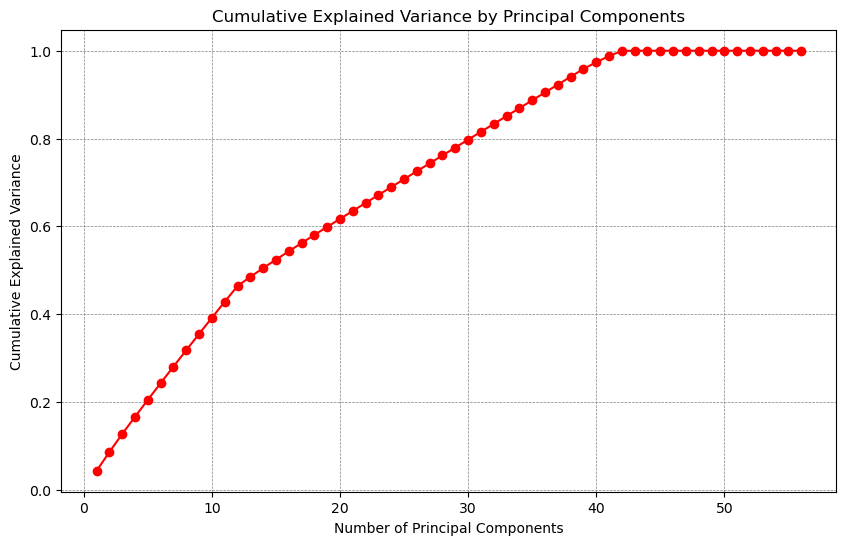

In [61]:
# Gráfico de varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', color = 'red')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [62]:
pca = PCA(n_components=30) 
products_pca = pca.fit_transform(products_scaled)

In [63]:
inertia_values = []
silhouette_scores = []

for n_clusters in range(2, 25):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
    kmeans.fit(products_pca)
    
    # Guardar la inercia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calcular el Silhouette Score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(products_pca, labels)
    silhouette_scores.append(silhouette_avg)

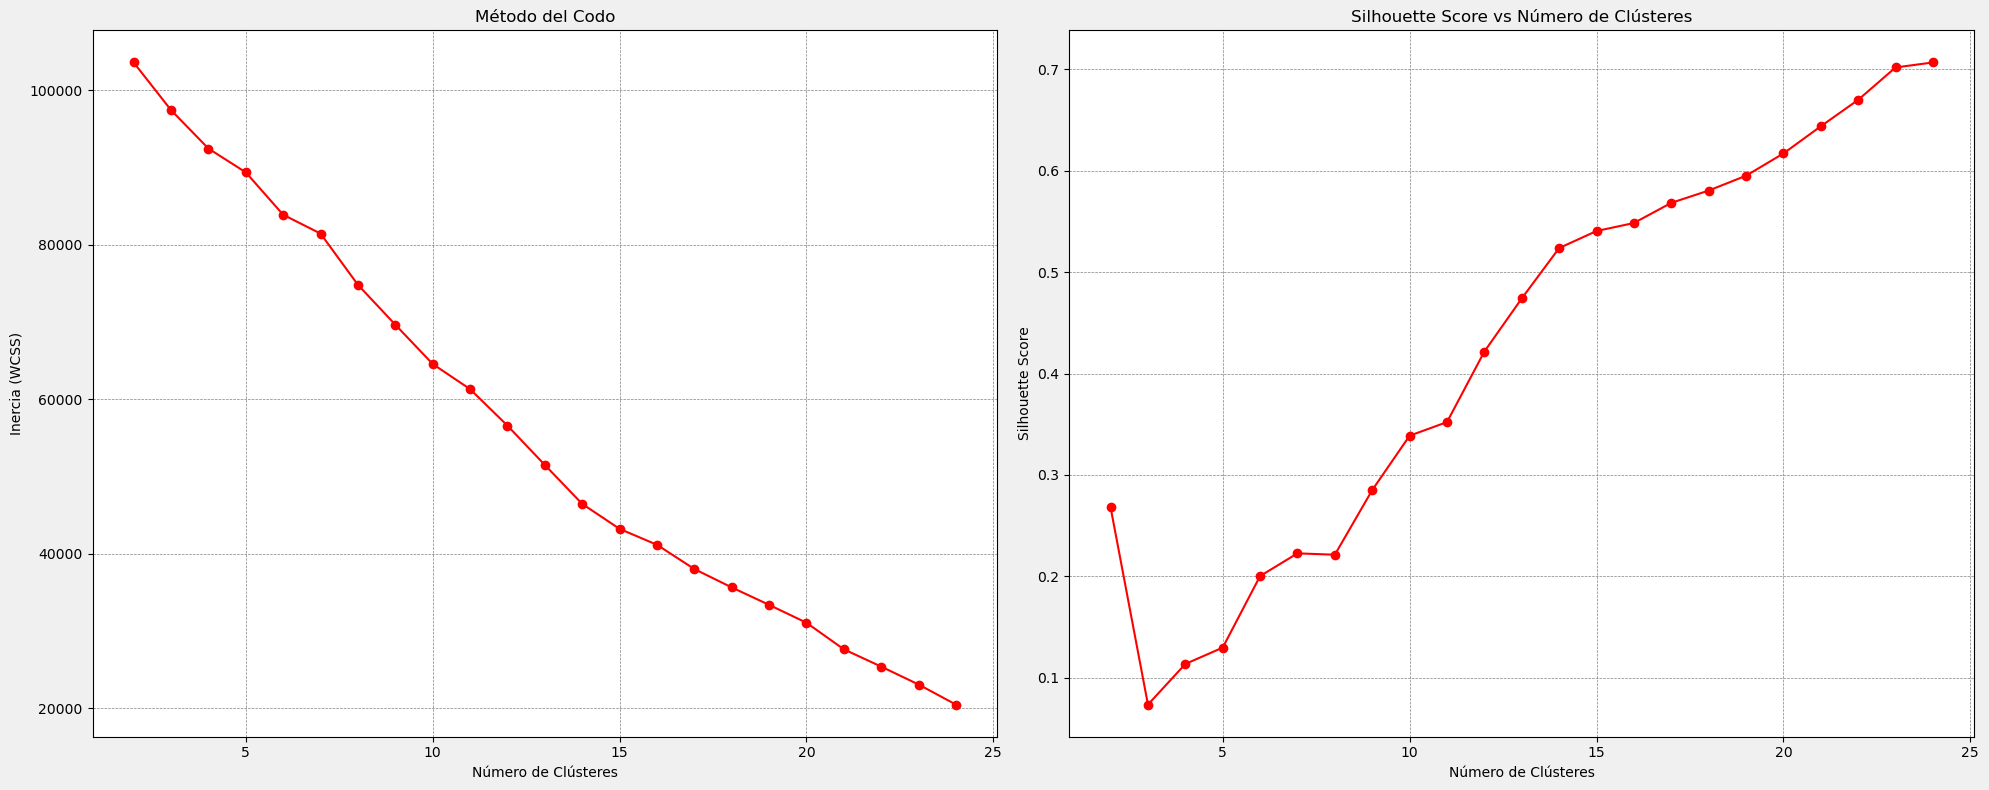

In [64]:
# Definir los colores personalizados
fondo_color_figura = '#F0F0F0'
fondo_color_ejes = '#FFFFFF'
line_color = 'red'
# Graficar el método del codo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor(fondo_color_figura)
    
    # Gráfico del método del codo
ax1.set_facecolor(fondo_color_ejes)
ax1.plot(range(2, len(inertia_values) + 2), inertia_values, marker='o', color=line_color)
ax1.set_title('Método del Codo', color='black')
ax1.set_xlabel('Número de Clústeres', color='black')
ax1.set_ylabel('Inercia (WCSS)', color='black')
ax1.tick_params(colors='black')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)  

    # Gráfico del Silhouette Score
ax2.set_facecolor(fondo_color_ejes)
ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o', color=line_color)
ax2.set_title('Silhouette Score vs Número de Clústeres', color='black')
ax2.set_xlabel('Número de Clústeres', color='black')
ax2.set_ylabel('Silhouette Score', color='black')
ax2.tick_params(colors='black')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)  
    
plt.tight_layout()
plt.show()

#### Sin PCA

In [66]:
# Encontrar el número óptimo de clústeres utilizando el método del codo y Silhouette Score
inertia_values = []
silhouette_scores = []

for n_clusters in range(2, 25):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
    kmeans.fit(products_scaled)
    
    # Guardar la inercia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calcular el Silhouette Score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(products_scaled, labels)
    silhouette_scores.append(silhouette_avg)

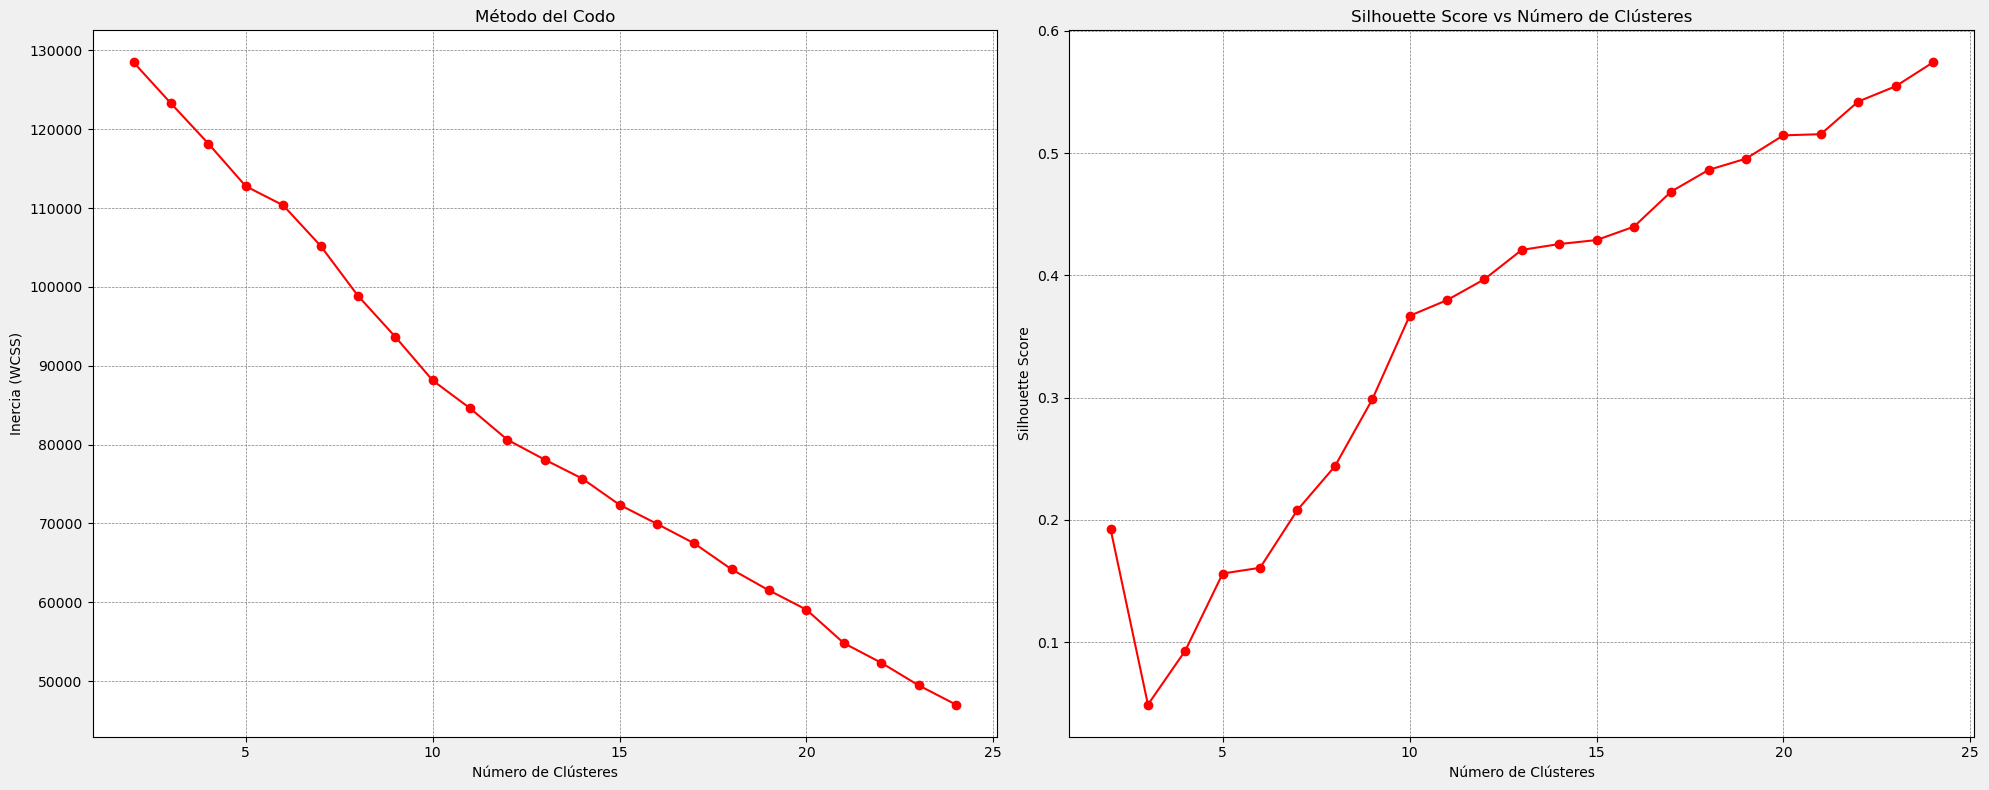

In [67]:
# Definir los colores personalizados
fondo_color_figura = '#F0F0F0'
fondo_color_ejes = '#FFFFFF'
line_color = 'red'
# Graficar el método del codo

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor(fondo_color_figura)
    
    # Gráfico del método del codo
ax1.set_facecolor(fondo_color_ejes)
ax1.plot(range(2, len(inertia_values) + 2), inertia_values, marker='o', color=line_color)
ax1.set_title('Método del Codo', color='black')
ax1.set_xlabel('Número de Clústeres', color='black')
ax1.set_ylabel('Inercia (WCSS)', color='black')
ax1.tick_params(colors='black')
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)  

# Gráfico del Silhouette Score
ax2.set_facecolor(fondo_color_ejes)
ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o', color=line_color)
ax2.set_title('Silhouette Score vs Número de Clústeres', color='black')
ax2.set_xlabel('Número de Clústeres', color='black')
ax2.set_ylabel('Silhouette Score', color='black')
ax2.tick_params(colors='black')
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)  

plt.tight_layout()
plt.show()

### Generamos los clusters

In [69]:
modelo = KMeans(n_clusters=21, random_state=42)
products_final['cluster_product'] = modelo.fit_predict(products_pca)

In [70]:
labels = modelo.labels_
silhouette_avg = silhouette_score(products_pca, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.617114355769944


In [71]:
products_final.cluster_product.unique()

array([ 2,  4,  8,  7, 13, 11,  0,  6,  9, 18, 12, 16,  5, 17, 15,  1, 19,
        3, 14, 10])

In [72]:
modelo.inertia_

31071.82881455783

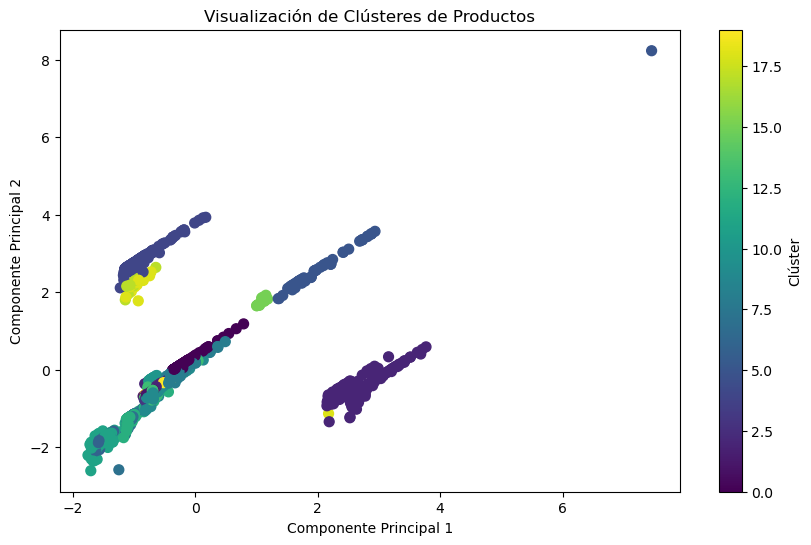

In [73]:
# Reducir la dimensionalidad a 2 componentes principales usando PCA
pca = PCA(n_components=2)
products_pca = pca.fit_transform(products_scaled)
# Crear un scatter plot para visualizar los clústeres
plt.figure(figsize=(10, 6))
plt.scatter(products_pca[:, 0], products_pca[:, 1], c=products_final['cluster_product'], cmap='viridis', s=50)
plt.title('Visualización de Clústeres de Productos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.show()

In [74]:
products_final.cluster_product.unique()

array([ 2,  4,  8,  7, 13, 11,  0,  6,  9, 18, 12, 16,  5, 17, 15,  1, 19,
        3, 14, 10])

## Elegimos los mejores productos en cada cluster basandonos en su rating

In [76]:
clusters_agrupados = products_final.sort_values(by=['cluster_product', 'rating', 'loves_count'], ascending=[True, False, False])
clusters_agrupados = clusters_agrupados[['product_id', 'loves_count', 'rating', 'cluster_product']]
clusters_agrupados.count()

product_id         2383
loves_count        2383
rating             2383
cluster_product    2383
dtype: int64

In [77]:
products_recommended = clusters_agrupados[clusters_agrupados['rating'] >= 4]
products_recommended.count()

product_id         1848
loves_count        1848
rating             1848
cluster_product    1848
dtype: int64

In [78]:
products_recommended[products_recommended['cluster_product']== 3].tail(5)

,product_id,loves_count,rating,cluster_product
1667,P441645,8889,4.2500,3
7326,P424989,22970,4.1959,3
7116,P407448,27207,4.1109,3
3573,P433155,11103,4.0313,3
1668,P442267,3650,4.0000,3


In [79]:
products_recommended[products_recommended['cluster_product']== 11].head(5)

,product_id,loves_count,rating,cluster_product
4153,P480176,3514,5.0,11
2028,P505332,1294,5.0,11
3318,P469801,1149,5.0,11
7500,P503877,689,5.0,11
3191,P505316,518,5.0,11


In [80]:
products_recommended[products_recommended['cluster_product']== 1].head(5)

,product_id,loves_count,rating,cluster_product
5058,P468390,2514,5.0000,1
5059,P470538,820,5.0000,1
5050,P457002,6806,4.8696,1
3402,P474838,1748,4.8636,1
3403,P482005,728,4.8171,1


In [81]:
products_recommended[products_recommended['cluster_product']== 5].head(5)

,product_id,loves_count,rating,cluster_product
5555,P504221,1085,5.0000,5
2713,P502818,918,5.0000,5
2161,P503906,191,5.0000,5
2717,P502831,1536,4.9231,5
2467,P476679,5082,4.8795,5


In [82]:
products_recommended = products_recommended.merge(
    products_final[['product_id', 'primary_category','secondary_category']],
    on = 'product_id',
    how = 'left'
)

In [83]:
products_recommended.head(2)

,product_id,loves_count,rating,cluster_product,primary_category,secondary_category
0,P500983,12280,5.0,0,Value & Gift Sets,Value & Gift Sets
1,P501886,7523,5.0,0,Value & Gift Sets,Value & Gift Sets


## Guardar en csv
Guardamos el csv final con todas las columnas y los productos ya clusterizados

In [85]:
products_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2383 entries, 89 to 8428
Data columns (total 98 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   product_id                         2383 non-null   object 
 1   product_name                       2383 non-null   object 
 2   brand_id                           2383 non-null   int64  
 3   brand_name                         2383 non-null   object 
 4   loves_count                        2383 non-null   int64  
 5   rating                             2383 non-null   float64
 6   reviews                            2383 non-null   float64
 7   size                               2383 non-null   object 
 8   variation_type                     2383 non-null   int64  
 9   ingredients                        2256 non-null   object 
 10  price_usd                          2383 non-null   float64
 11  limited_edition                    2383 non-null   int64  
 

In [86]:
products_final.to_csv('products_final.csv', index=False)

In [87]:
products_recommended.to_csv('products_recommended.csv', index = False)